# **Unsupervised Machine Learning: Mall Customers.**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix
from scipy.cluster import hierarchy 
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import scipy.cluster.hierarchy as sch
import warnings

pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

### **Starting from the hypothesis in which we believe that the most significant variables to find potential customers for the sale of products are the spending score and annual income.**

# **EXPLORATORY ANALYSIS.**

In [2]:
df = pd.read_csv('Mall_Customers.csv')

#### **Proceed to visualize, determine dimensions and types of the Dataset.**

In [3]:
df.head() 

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.shape 

(200, 5)

In [5]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

### **Variable description:**
*	**CustomerID**: Unique customer identifier.
*	**Gender**: Customer gender.
*	**Age**: Customer age.
*	**Annual Income (k$)**: Annual customer income.
*	**Spending Score (1-100)**: Score related to the level of customer spending.

#### **set certain summary metrics of interest.**

In [6]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.00,200.00,200.00,200.00
mean,100.50,38.85,60.56,50.20
std,57.88,13.97,26.26,25.82
min,1.00,18.00,15.00,1.00
25%,50.75,28.75,41.50,34.75
50%,100.50,36.00,61.50,50.00
75%,150.25,49.00,78.00,73.00
max,200.00,70.00,137.00,99.00


#### **Because it is a categorical variable, Gender receives a special examination.**

In [7]:
df.Gender.value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

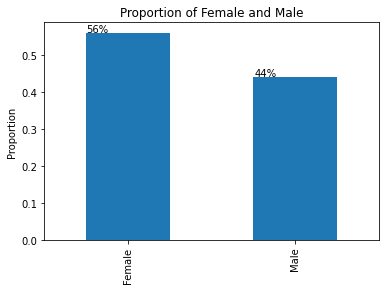

In [8]:
grafico=df.Gender.value_counts(normalize=True).plot.bar(ylabel='Proportion', title='Proportion of Female and Male')
plt.ticklabel_format(style="plain", axis="y")
for p in grafico.patches:
    grafico.annotate(str(round(p.get_height()*100))+'%', (p.get_x() * 1.005, p.get_height() * 1.005))

#### **For convenience, we renamed some features.**

In [9]:
#Rename the columns.
df.rename(columns={'Annual Income (k$)':'Annual_Income', 'Spending Score (1-100)':'Spending_Score'}, inplace=True) 

In [10]:
df.head()

,CustomerID,Gender,Age,Annual_Income,Spending_Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


#### **As it lacks relevance for the present exploratory analysis, the CostumerID feature has been removed.**

In [11]:
#Save the values of the clients because they will be necessary to be able to identify to which cluster each client belongs
customers_id = df['CustomerID']
df.drop(columns='CustomerID',inplace=True) #Remove the CustomerID column because it is not relevant for the analysis

In [12]:
df.head()

,Gender,Age,Annual_Income,Spending_Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


# **VARIABLE ENGINEERING.**

### **Detection and treatment of null values.**

In [13]:
df.isnull().sum()

Gender            0
Age               0
Annual_Income     0
Spending_Score    0
dtype: int64

#### The Dataset does not present null data.

### **Detection and treatment of Outliers.**

In [14]:
#The function receives a dataframe and a column name and returns statistical data related to the outliers.
def get_iqr_values(df_in, col_name):
    mediana = df_in[col_name].median()
    q1 = df_in[col_name].quantile(0.25) #1st quantil.
    q3 = df_in[col_name].quantile(0.75) #3rd quantil.
    iqr = q3-q1 #Rango intercuartilico
    minimo  = q1-1.5*iqr #Minimum value (marker |- in the boxplot).
    maximo = q3+1.5*iqr #Maximum value (marked -| in the boxplot).
    return mediana, q1, q3, iqr, minimo, maximo

#The function receives a dataframe and the name of the column and returns the text formatted with the statistical data from the get_iqr_values function.
def get_iqr_text(df_in, col_name):
    mediana, q1, q3, iqr, minimo, maximo = get_iqr_values(df_in, col_name)
    text = f"mediana={mediana:.2f}, q1={q1:.2f}, q3={q3:.2f}, iqr={iqr:.2f}, minimo={minimo:.2f}, maximo={maximo:.2f}"
    return text

#The function receives a dataframe and the column name and returns the dataframe without the outliers.
def remove_outliers(df_in, col_name):
    _, _, _, _, minimo, maximo = get_iqr_values(df_in, col_name)
    df_out = df_in.loc[(df_in[col_name] > minimo) & (df_in[col_name] < maximo)]
    return df_out

#The function receives a dataframe and the name of the column and returns the number of outliers that column has.
def count_outliers(df_in, col_name):
    _, _, _, _, minimo, maximo = get_iqr_values(df_in, col_name)
    df_outliers = df_in.loc[(df_in[col_name] <= minimo) | (df_in[col_name] >= maximo)]
    return df_outliers.shape[0]

#The function receives the name of a dataframe and the name of a column and plots a boxplot.
def boxplot(df_in, col_name):
    title = get_iqr_text(df_in, col_name)
    sns.boxplot(df_in[col_name])
    plt.title(title)
    plt.show()
    
#The function receives a dataframe and iterates through each of the numeric columns to remove all outliers or up to a maximum of 
#100 iterations, returns the dataframe without the outliers, and displays the number of outliers removed.
def remove_all_outliers(df_in):
    columns=df.select_dtypes(include=['float64','int64']).columns
    totalOutliers=0
    for col_name in columns:
        loop_count = 0
        outlier_count = count_outliers(df_in, col_name)
        
        while outlier_count > 0:
            loop_count += 1

            if (loop_count > 100):
                break  
            
            totalOutliers += count_outliers(df_in, col_name)
            df_in = remove_outliers(df_in, col_name)
            outlier_count = count_outliers(df_in, col_name)  
            
    print(totalOutliers, "Outliers removed",)
    return df_in

print("Defined functions...")

Defined functions...


Age has 0 outliers


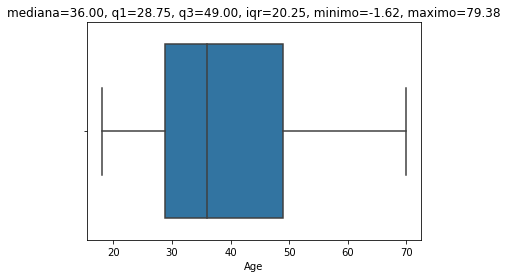

Annual_Income has 2 outliers


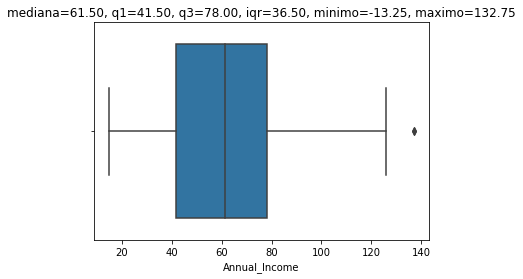

Spending_Score has 0 outliers


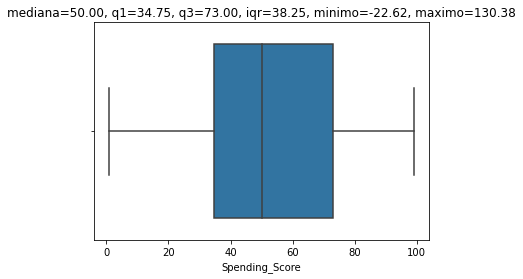

In [15]:
#Iterate through the numeric columns of the dataset to plot the outliers and describe the distribution of the variables.
for column in (df.select_dtypes(include=['float64','int64']).columns):
    print(f"{column} has {count_outliers(df, column)} outliers")
    boxplot(df, column);

#### **For perspective viewing.**

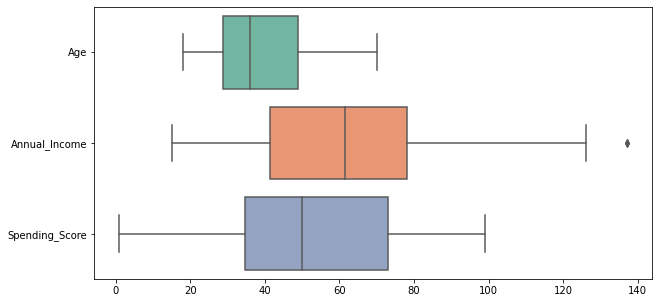

In [16]:
plt.figure(figsize = (10,5))
sns.boxplot(data = df, orient="h", palette="Set2")

plt.show();

#### **From the analysis, the conclusion arises to eliminate two extreme data from the Annual_Income feature.**

In [17]:
df_completo = df.copy()
df = remove_all_outliers(df)

2 Outliers removed


### **Behavior analysis.**

#### **In order to know and identify relationships between the features of the Dataset, some graphs are made.**

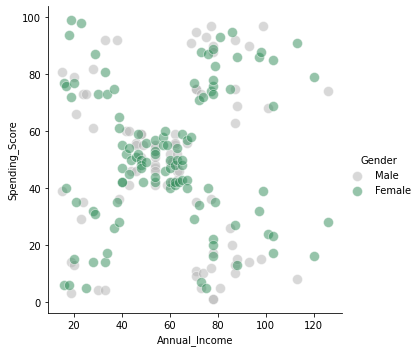

In [18]:
pal = dict(Female="seagreen", Male=".7")
g = sns.FacetGrid(df, hue="Gender", palette=pal, height=5)
g.map(sns.scatterplot, "Annual_Income", "Spending_Score", s=100, alpha=.5)
g.add_legend();

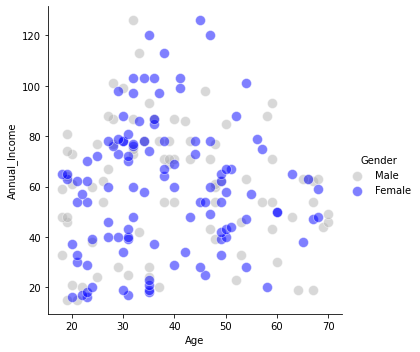

In [19]:
pal = dict(Female="blue", Male=".7")
g = sns.FacetGrid(df, hue="Gender", palette=pal, height=5)
g.map(sns.scatterplot, "Age", "Annual_Income", s=100, alpha=.5)
g.add_legend();

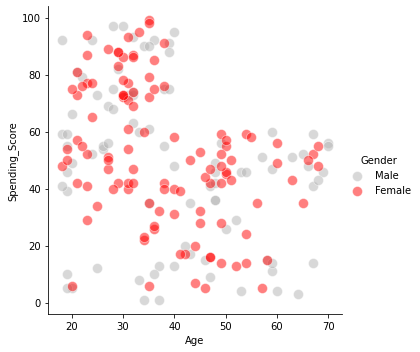

In [20]:
pal = dict(Female="red", Male=".7")
g = sns.FacetGrid(df, hue="Gender", palette=pal, height=5)
g.map(sns.scatterplot, "Age", "Spending_Score", s=100, alpha=.5)
g.add_legend();

#### **Preliminary conclusions:** 
Clear differences are not observed when considering behavior by gender, which gives us an indication that both categories share characteristics and the selection between one and the other would be indistinguishable. On the other hand, both higher incomes and higher expense scores appear visually in the age range between 25 and 40 years old.

### **Distribution analysis.**

#### The first step of distribution analysis requires us to code the gender variable.

In [21]:
enc=OneHotEncoder() #Instantiate the object
#Create the columns with their respective name, and with the fit transform I assign a value of 1 or 0, and pass it to 
#an array to create the new dataframe
aux=pd.DataFrame(enc.fit_transform(df[['Gender']]).toarray(), columns=['F', 'M'])  
df=df.join(aux)
df=df.drop(['Gender'], axis=1)

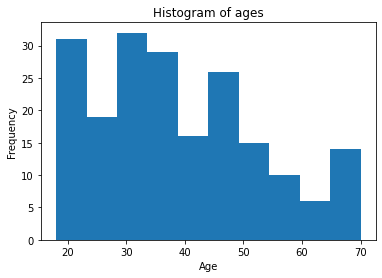

In [22]:
edades = df.Age.values
plt.hist(x=edades)
plt.title('Histogram of ages')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.show() 

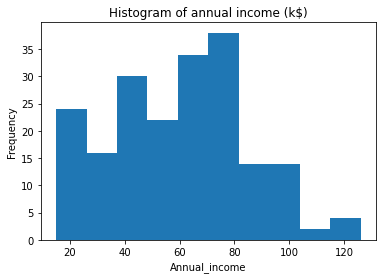

In [23]:
annual_income = df.Annual_Income.values
plt.hist(x=annual_income)
plt.title('Histogram of annual income (k$)')
plt.xlabel('Annual_income')
plt.ylabel('Frequency')

plt.show() 

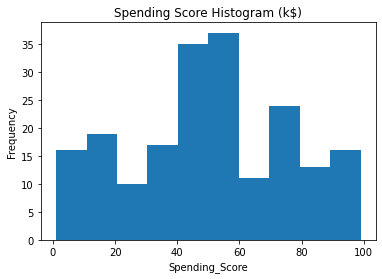

In [24]:
spending_score = df.Spending_Score.values
plt.hist(x=spending_score)
plt.title('Spending Score Histogram (k$)')
plt.xlabel('Spending_Score')
plt.ylabel('Frequency')

plt.show() 

#### **Finally, carry out a correlation analysis with the intention of better understanding how some variables behave with others.**

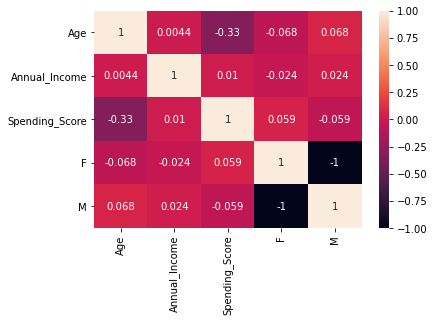

In [25]:
sns.heatmap(df.corr(),
           annot=True);

**We found an inverse correlation between spending score and age, which makes sense.**

In [26]:
#Selection of the two variables of interest from the dataset without outliers.
df=df[['Annual_Income','Spending_Score']]

In [27]:
#Copy of the dataset to evaluate after training the model with the complete data with outliers
df_completo = df_completo[['Annual_Income','Spending_Score']]

# **Unsupervised Learning Models**. 

# **SEGMENTATION WITH K-MEANS.** 

#### First, perform a variable scaling. In this case, use the MinMaxScaler method (coding the variables between 0 and 1).

In [28]:
#Perform two scales, one for each dataset (with and without outliers).
scaler = MinMaxScaler()
scaler2 = MinMaxScaler()
values_scaler = pd.DataFrame(scaler.fit_transform(df))
values_scaler2 = pd.DataFrame(scaler2.fit_transform(df_completo))

In [29]:
#Scale each variable in the dataset.
index=-1
for columns in df:
    index+=1
    df[columns] = values_scaler[index]
    
index2=-1
for columns2 in df_completo:
    index2+=1
    df_completo[columns2] = values_scaler2[index2]

**Visualization of the dataset.**

In [30]:
df_completo.head()

,Annual_Income,Spending_Score
0,0.00,0.39
1,0.00,0.82
2,0.01,0.05
3,0.01,0.78
4,0.02,0.40


#### Second, perform model training.

In [31]:
#Take into account the X values to be trained and those that are to be predicted.
X= df[['Annual_Income','Spending_Score']].values
X_to_pred = df_completo[['Annual_Income','Spending_Score']].values

### **In search of the hyperparameter K.**

#### For the selection of the optimal value of the hyperparameter K we will use both the method of the silhouette and the method of the elbow.

### Silhouette score.

For n_clusters = 2 The average silhouette_score is : 0.31916358511714177
For n_clusters = 3 The average silhouette_score is : 0.45462698579924626
For n_clusters = 4 The average silhouette_score is : 0.4999162571098343
For n_clusters = 5 The average silhouette_score is : 0.5640959164678206
For n_clusters = 6 The average silhouette_score is : 0.46124573925575213


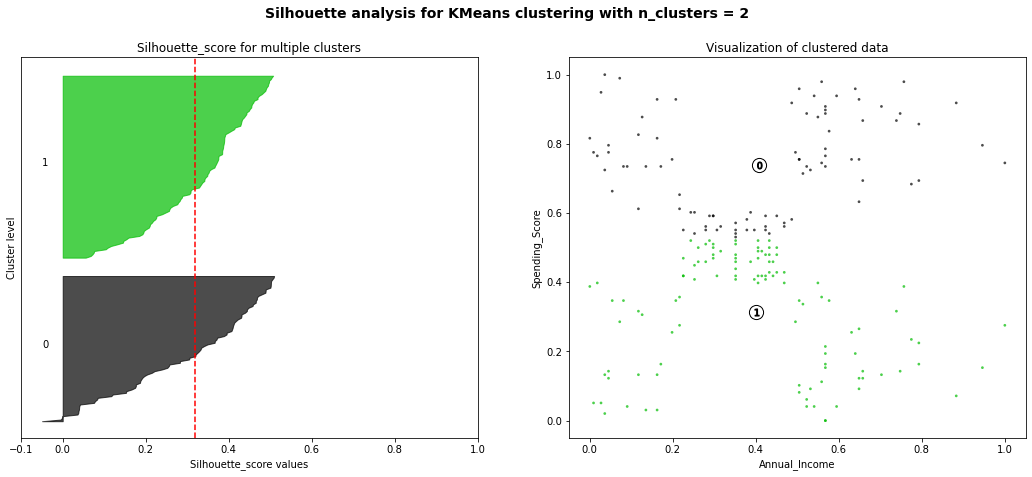

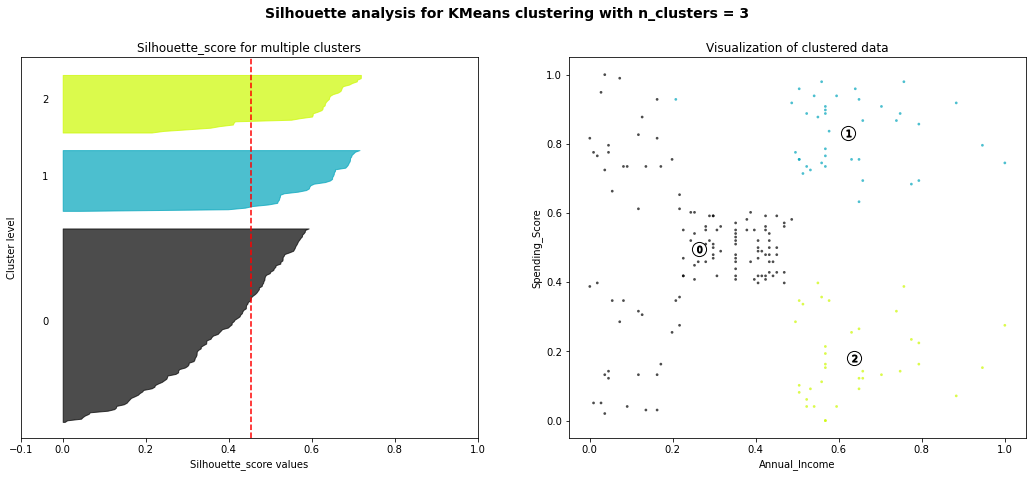

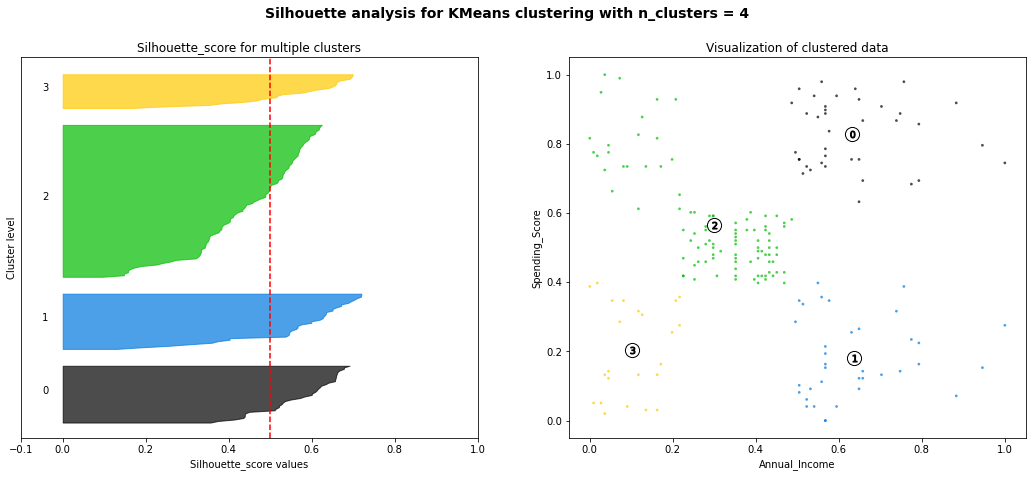

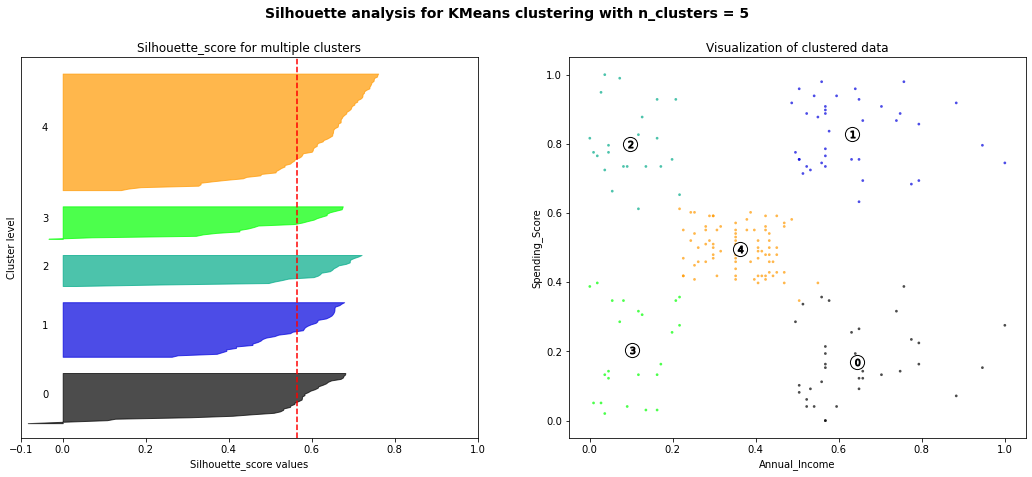

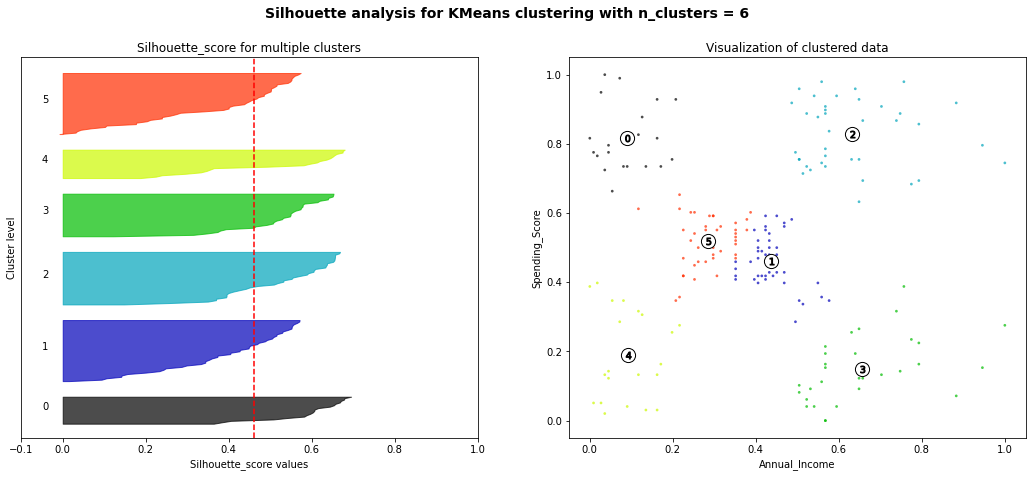

In [32]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    #Create a subplot with 1 row and 2 columns.
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    #The 1st subplot is the silhouette plot.
    #The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1].
    ax1.set_xlim([-0.1, 1])
    #The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, 
    #to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    #Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    #The silhouette_score gives the average value for all the samples.
    #This gives a perspective into the density and separation of the formed clusters.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    #Compute the silhouette scores for each sample.
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        #Aggregate the silhouette scores for samples belonging to cluster i, and sort them.
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        #Label the silhouette plots with their cluster numbers at the middle.
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        #Compute the new y_lower for next plot.
        y_lower = y_upper + 10  #10 for the 0 samples.

    ax1.set_title("Silhouette_score for multiple clusters")
    ax1.set_xlabel("Silhouette_score values")
    ax1.set_ylabel("Cluster level")

    #The vertical line for average silhouette score of all the values.
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  #Clear the yaxis labels / ticks.
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #2nd Plot showing the actual clusters formed.
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    #Labeling the clusters.
    centers = clusterer.cluster_centers_
    #Draw white circles at cluster centers.
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualization of clustered data")
    ax2.set_xlabel("Annual_Income")
    ax2.set_ylabel("Spending_Score")

    plt.suptitle(("Silhouette analysis for KMeans clustering"
                  " with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show();

#### **Preliminary conclusions:** 

Although it is graphically intuited that K = 6 could be the best choice, when observing the average silhouette score, it gives us an indication that K = 5 may be a good option, so we will corroborate with the elbow method.

### Elbow method.

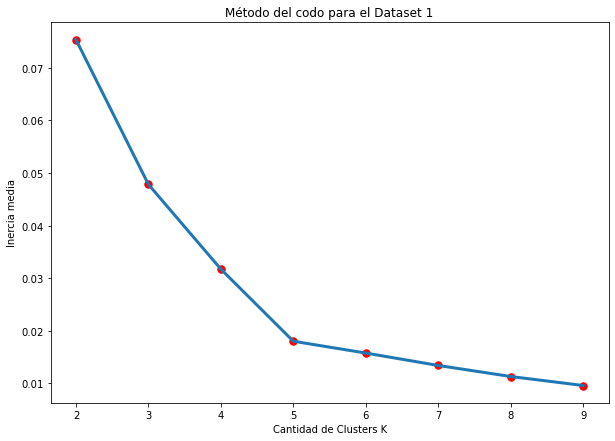

In [33]:
Sum_of_squared_distances = []
K = np.arange(2,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    distancia_total = km.inertia_
    distancia_media = np.divide(distancia_total,X.shape[0])
    Sum_of_squared_distances.append(distancia_media)
#Grafica de la suma de las distancias
plt.figure(figsize = (10,7))
plt.plot(K, Sum_of_squared_distances, lw=3)
plt.scatter(K, Sum_of_squared_distances,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Inercia media')
plt.title('Método del codo para el Dataset 1')

plt.show();

#### Conclusion: The elbow method reaffirms our preliminary conclusion. In this way, the value of the hyperparameter K, or number of clusters to take into account in the clustering, will be equal to 5.

In [34]:
#Set the hyperparameters.
kmeans = KMeans(n_clusters=5, random_state=0)

### Identification of groups with K - MEANS.

In [35]:
#Train with the dataset without outliers and predict with the dataset with outliers.
kmeans.fit(X)
y_kmeans = kmeans.fit_predict(X_to_pred)

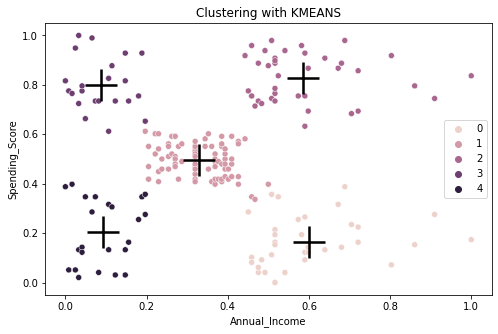

In [36]:
plt.figure(figsize = (8,5))
etiquetas = kmeans.labels_
centros = kmeans.cluster_centers_
sns.scatterplot(X_to_pred[:, 0], X_to_pred[:, -1], hue = etiquetas)
sns.scatterplot(centros[:, 0], centros[:, 1],color='black', marker="+", s=1000)
plt.title('Clustering with KMEANS')
plt.xlabel('Annual_Income')
plt.ylabel('Spending_Score')
plt.show()

#### In this way, five groups of clients can be seen that differ in income levels and expense scores.

In [37]:
df_completo['y_kmeans'] = y_kmeans

# **SEGMENTATION WITH DBSCAN.** 

#### Clarification:
Given the problem and dataset being worked with, the DBSCAN unsupervised learning model does not seem to be the most optimal, unlike KMEANS. Therefore, since we do not have metrics to select DBSCAN hyperparameters, which are *eps* and *min_samples*, we will proceed to choose them arbitrarily with the attempt to achieve a figure that is as similar as possible to the one obtained by the KMEANS method.

In [38]:
#Set the hyperparameters.
db = DBSCAN(eps=0.092, min_samples=4)

In [39]:
#Train the model.
db.fit(X)

DBSCAN(eps=0.092, min_samples=4)

In [40]:
#Obtain the estimated number of clusters and noise or outliers.
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

In [41]:
print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of outliers: %d' % n_noise)

Estimated number of clusters: 5
Estimated number of outliers: 13


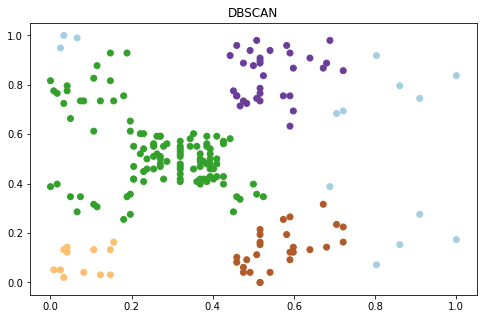

In [42]:
plt.figure(figsize = (8,5))
db2 = DBSCAN(eps=0.092, min_samples=4)
db2.fit(X)
y_pred = db2.fit_predict(X_to_pred)
plt.scatter(X_to_pred[:,0], X_to_pred[:,1],c=y_pred, cmap='Paired')
plt.title("DBSCAN");

#### SIn this way, the objective sought is fulfilled: to find a configuration that is similar to the one found with KMEANS.

### Agglomerative

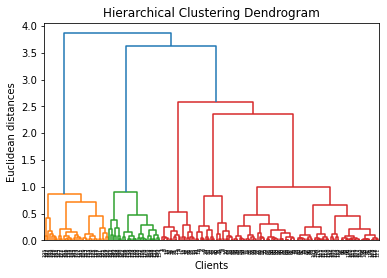

In [43]:
#Plot the dendrogram
dendograma = sch.dendrogram(sch.linkage(X, method = 'ward'))

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Clients')
plt.ylabel('Euclidean distances')
plt.show();

**We will make the cut in 5 clusters that is the most significant for our problem where you can see that the clusters are formed in the best possible way.**

In [44]:
#Define the model with 5 clusters and predict.
agg = AgglomerativeClustering(n_clusters = 5, 
                    affinity = 'euclidean', 
                    linkage = 'ward')

y_pred = agg.fit_predict(X_to_pred)

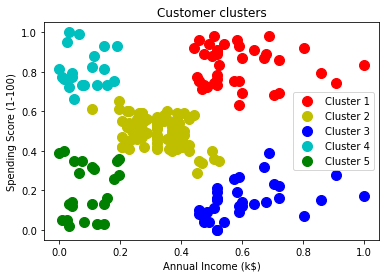

In [45]:
#Plot the hierarchical cluster with the given predictions.
plt.scatter(X_to_pred[y_pred == 0, 0], X_to_pred[y_pred == 0, 1], s = 100, c = 'r', label = 'Cluster 1')
plt.scatter(X_to_pred[y_pred == 1, 0], X_to_pred[y_pred == 1, 1], s = 100, c = 'y', label = 'Cluster 2')
plt.scatter(X_to_pred[y_pred == 2, 0], X_to_pred[y_pred == 2, 1], s = 100, c = 'b', label = 'Cluster 3')
plt.scatter(X_to_pred[y_pred == 3, 0], X_to_pred[y_pred == 3, 1], s = 100, c = 'c', label = 'Cluster 4')
plt.scatter(X_to_pred[y_pred == 4, 0], X_to_pred[y_pred == 4, 1], s = 100, c = 'g', label = 'Cluster 5')
plt.title('Customer clusters')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

**Finally, we add the *customerID* variable that we had saved in a variable to identify which cluster each segmented customer belongs to.**

In [46]:
df_completo['CustomerID']= customers_id

In [47]:
df_completo.head()

,Annual_Income,Spending_Score,y_kmeans,CustomerID
0,0.00,0.39,4,1
1,0.00,0.82,3,2
2,0.01,0.05,4,3
3,0.01,0.78,3,4
4,0.02,0.40,4,5


## Conclusions:

**Cluster 1: Standard** 
- They represent the highest income of the business;
- Show fidelity;
- Show discretion in purchases.

**Cluster 2: Premium**
- Knows and is interested in the products offered;
- Show fidelity;
- The one who can afford luxuries in purchases without ending up with debts.

**Cluster 3: Unmotivated**
- Show indifference;
- Possible ignorance of the use of the platform or products offered.

**Cluster 4: Wasteful spender**
- Show fidelity;
- Don't show restraint in purchases.

**Cluster 5: Saver**
- Show prudence.